In [1]:
import os
import cv2
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, optimizers, models, regularizers
from tensorflow.keras.utils import plot_model
from time import time_ns
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

In [2]:
from losses import custom_loss, custom_loss_2

In [3]:
fixed_seed_num = 1234
np.random.seed(fixed_seed_num)
tf.random.set_seed(fixed_seed_num)
x_shape=512
y_shape=512

In [4]:
def generator_model(x_shape, y_shape):
    #encoder
    generator_input = layers.Input(batch_shape=(None, x_shape, y_shape, 1), name="generator_input")
    generator_input_normalized = layers.BatchNormalization()(generator_input)

    conv1_32 = layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(generator_input)
    conv1_32 = layers.BatchNormalization()(conv1_32)

    conv2_64 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv1_32)
    conv2_64 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv2_64)
    conv2_64 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv2_64)
    conv2_64 = layers.BatchNormalization()(conv2_64)

    conv3_128 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv2_64)
    conv3_128 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv3_128)
    conv3_128 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv3_128)
    conv3_128 = layers.BatchNormalization()(conv3_128)

    conv4_256 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv3_128)
    conv4_256 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv4_256)
    conv4_256 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv4_256)
    conv4_256 = layers.BatchNormalization()(conv4_256) 

    conv5_512 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv4_256)
    conv5_512 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv5_512)
    conv5_512 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv5_512)
    conv5_512 = layers.BatchNormalization()(conv5_512)

    conv6_512 = layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv5_512)
    conv6_512 = layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv6_512)
    conv6_512 = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv6_512)
    conv6_512 = layers.BatchNormalization()(conv6_512)

    conv7_512 = layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv6_512)
    conv7_512 = layers.BatchNormalization()(conv7_512)

    #decoder
    conv8_512 = layers.Conv2D(512, kernel_size=(3,3), padding="same", activation='elu', kernel_regularizer=regularizers.l2(0.001))(conv7_512)
    conv8_512 = layers.BatchNormalization(axis=1)(conv8_512)

    deconv9_512 = layers.Conv2DTranspose(512, kernel_size=(3, 3), padding='same', activation='elu', strides=(2,2), kernel_regularizer=regularizers.l2(0.001))(conv8_512)
    deconv9_512 = layers.BatchNormalization()(deconv9_512)
    deconv9_512 = layers.Concatenate()([deconv9_512, conv5_512])
    deconv9_512 = layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(deconv9_512)
    deconv9_512 = layers.BatchNormalization()(deconv9_512)
    
    deconv10_256 = layers.Conv2DTranspose(512, kernel_size=(3, 3), padding='same', activation='elu', strides=(2,2), kernel_regularizer=regularizers.l2(0.001))(deconv9_512)
    deconv10_256 = layers.BatchNormalization()(deconv10_256)
    deconv10_256 = layers.Concatenate()([deconv10_256, conv4_256])
    deconv10_256 = layers.Conv2D(512, kernel_size=(3,3), padding='same', activation='elu', kernel_regularizer=regularizers.l2(0.001))(deconv10_256)
    deconv10_256 = layers.BatchNormalization()(deconv10_256)

    deconv11_128 = layers.Conv2DTranspose(128,kernel_size=(3,3),padding='same',activation='elu',strides=(2,2),kernel_regularizer=regularizers.l2(0.001))(deconv10_256)
    deconv11_128 = layers.Concatenate()([deconv11_128,conv3_128])
    deconv11_128 = layers.Conv2D(128,kernel_size=(3,3),padding='same',activation='elu',kernel_regularizer=regularizers.l2(0.001))(deconv11_128)
    
    deconv12_64 = layers.Conv2DTranspose(64,kernel_size=(3,3),padding='same',activation='elu',strides=(2,2),kernel_regularizer=regularizers.l2(0.001))(deconv11_128)
    deconv12_64 = layers.Concatenate()([deconv12_64,conv2_64])
    deconv12_64 = layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='elu',kernel_regularizer=regularizers.l2(0.001))(deconv12_64)
    
    deconv13_32 = layers.Conv2DTranspose(32,kernel_size=(3,3),padding='same',activation='elu',strides=(2,2),kernel_regularizer=regularizers.l2(0.001))(deconv12_64)
    deconv13_32 = layers.Concatenate()([deconv13_32,conv1_32])
    deconv13_32 = layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='elu',kernel_regularizer=regularizers.l2(0.001))(deconv13_32)
    
    deconv14_16 = layers.Conv2DTranspose(16,kernel_size=(3,3),padding='same',activation='elu',kernel_regularizer=regularizers.l2(0.001))(deconv13_32)
    deconv14_16 = layers.Conv2D(16,kernel_size=(3,3),padding='same',activation='elu',kernel_regularizer=regularizers.l2(0.001))(deconv14_16)
 
    output = layers.Conv2D(3, kernel_size=(1,1), padding='same', activation='relu')(deconv14_16)
    model = models.Model(inputs=generator_input, outputs=output)
    return model


In [5]:
def discriminator_model(x_shape, y_shape):
    generator_input = layers.Input(batch_shape=(None, x_shape, y_shape, 1), name='generator_output')
    generator_output = layers.Input(batch_shape=(None, x_shape, y_shape, 3), name='generator_input')

    input1 = layers.BatchNormalization()(generator_input)
    input2 = layers.BatchNormalization()(generator_output)

    convi = layers.Conv2D(32, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(generator_input)
    convi = layers.BatchNormalization()(convi)

    convo = layers.Conv2D(32, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(generator_output)
    convo = layers.BatchNormalization()(convo)

    convi = layers.Conv2D(64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(convi)
    convi = layers.BatchNormalization()(convi)

    convo = layers.Conv2D(64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(convo)
    convo = layers.BatchNormalization()(convo)

    convi = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(convi)
    convo = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(convo)

    conv = layers.Concatenate()([convi, convo])
    conv = layers.BatchNormalization()(conv)

    conv = layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(conv)
    conv = layers.BatchNormalization()(conv)

    conv = layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(conv)
    conv = layers.BatchNormalization()(conv)

    conv = layers.Conv2D(256, kernel_size=(3,3), strides=(2,2), activation='elu', padding='same', kernel_regularizer=regularizers.l2(0.001))(conv)
    conv = layers.BatchNormalization()(conv)

    conv = layers.Conv2D(256, kernel_size=(3,3), strides=(2,2), activation='elu', padding='same')(conv)
    conv = layers.BatchNormalization()(conv)

    conv = layers.Flatten()(conv)
    conv = layers.Dropout(0.5)(conv)

    conv = layers.Dense(100, activation='elu')(conv)
    conv = layers.Dropout(0.5)(conv)

    output = layers.Dense(1, activation='sigmoid')(conv)

    model = models.Model(inputs=([generator_input, generator_output]), outputs=output)

    return model

In [6]:

def cGAN_model(generator, discriminator):
    discriminator.trainable = False
    model = models.Model(inputs=generator.inputs, outputs=[discriminator([generator.input, generator.output]), generator.output])
    return model

In [7]:
gen = generator_model(x_shape, y_shape)
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_input (InputLayer)   [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['generator_input[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 rmalization)                   )                                                             

In [8]:
disc = discriminator_model(x_shape, y_shape)
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_output (InputLayer)  [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 generator_input (InputLayer)   [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 32  320         ['generator_output[0][0]']       
                                )                                                           

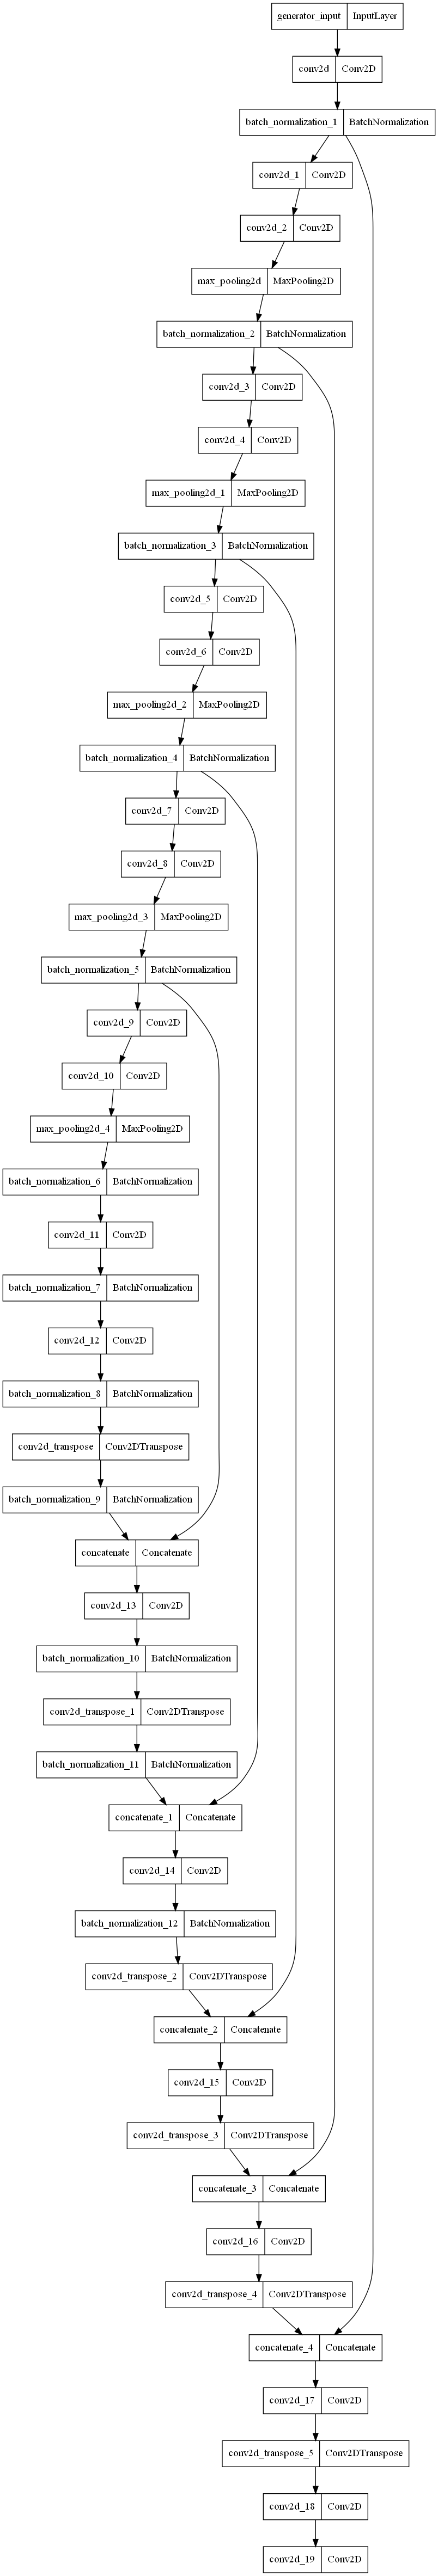

In [12]:
plot_model(gen)

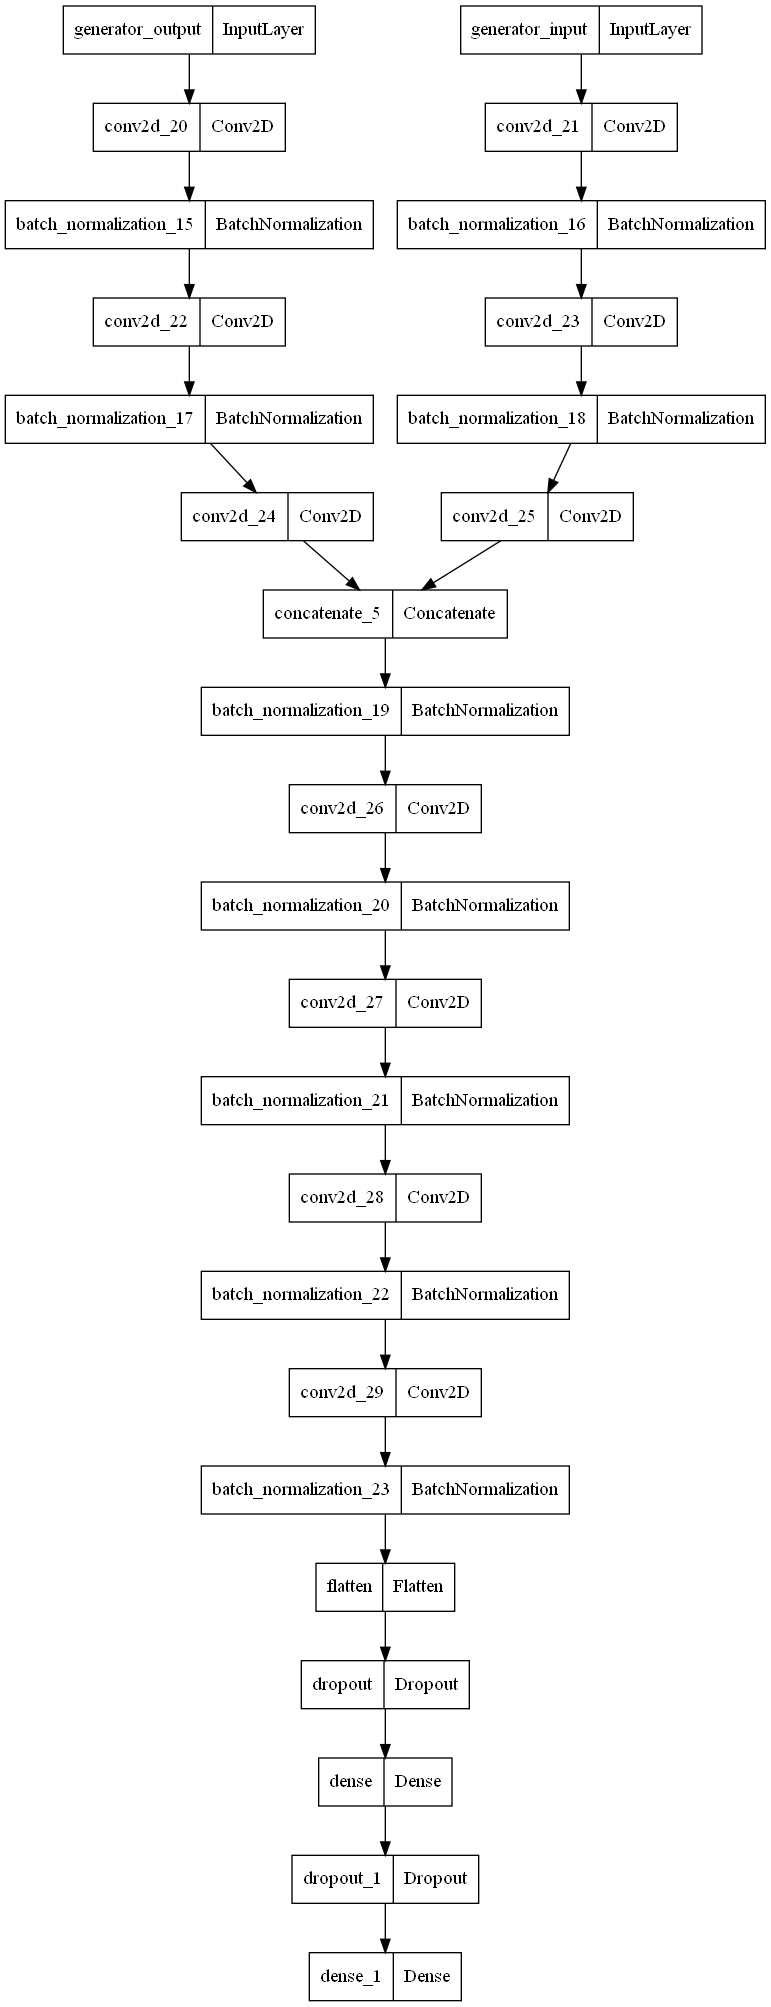

In [9]:
plot_model(disc, to_file='generator_model.png')

In [11]:
def train(gen, disc, cGAN, gray, rgb, gray_val, rgb_val, batch):
    samples = len(rgb)
    gen_image = gen.predict(gray, batch_size=16)
    gen_image_val = gen.predict(gray_val, batch_size=8)
    inputs = np.concatenate([gray, gray])
    outputs = np.concatenate([rgb, gen_image])
    y = np.concatenate([np.ones((samples, 1)), np.zeros((samples, 1))])
    disc.fit([inputs, outputs], y, epochs=1, batch_size=4)
    disc.tranable = False
    cGAN.fit(gray, [np.ones((samples, 1)), rgb], epochs=1, batch_size=batch, callbacks=[tensorboard], validation_data=[gray_val, [np.ones((val_samples, 1)), rgb_val]])